### The purpose of this notebook is to write code that will track the starlink satellites and output their positions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from satellites import load_satellites, get_satellites, get_pos, get_visible, separation_matrix
import skyfield.api
from skyfield.api import Topos, load
import datetime
import scipy

In [2]:
KPNO = skyfield.toposlib.Topos(
    latitude_degrees=31.963972222,
    longitude_degrees=-111.599336111,
    elevation_m=2120)

In [3]:
ts=skyfield.api.load.timescale()
t = ts.utc(2019, 8, 26, 11, 20, 5)
t1 = ts.utc(2019, 8 , 26, 11, 20, 5)
t1_end = ts.utc(2019, 8, 26, 11, 21, )

In [ ]:
#this function gives RA, DEC for a selected satellite
#to generalize to a list of satellites: could change to def radec(satellites, where, tbegin, exptime): where satellites is a
#skyfield dictionary of satellites, and I loop through each satellite to get their RA, DEC
'''def radec(satellite, where, tbegin, exptime):
	#satellite is an EarthSatellite object from skyfield
	#where is the skyfield.Topos object with lat, lon, and alt
	#tbegin is the beginning time to calculate position
	#exptime is how long to calculate for in seconds
	ra, dec = [], []
	time_delta = np.linspace(0, exptime, exptime)
	for second in time_delta:
		time = ts.utc(tbegin.utc_datetime() + datetime.timedelta(seconds=second))
		difference = satellite - where
		topocentric = difference.at(time)
		ra2, dec2, d2 = topocentric.radec() #ICRF COORDS SINCE EPOCH NOT SPECIFIED
		ra.append(ra2._degrees)
		dec.append(dec2._degrees)
	return ra, dec'''

In [4]:
#I will define a similar function to give ALT, AZ for a single satellite
def altaz(satellite, where, tbegin, exptime):
    #satellite is an EarthSatellite object from skyfield
    #where is the skyfield.Topos object with lat, lon, and alt
    #tbegin is the beginning time to caluclate position
    #exptime is how long to calculate for in seconds
    #returns alt, az in DEGREES
    alt, az = [], []
    time_delta = np.linspace(0, exptime, exptime)
    for second in time_delta:
        time = ts.utc(tbegin.utc_datetime() + datetime.timedelta(seconds=second))
        difference = satellite - where
        topocentric = difference.at(time)
        alt2, az2, d2 = topocentric.altaz()
        if alt2.radians <0:
            continue
        alt.append(alt2.degrees)
        az.append(az2.degrees)
    return np.array(alt), np.array(az)

In [ ]:
# need a function that will calculate the RA, DEC (OR ALT, AZ) of starlink satellites over the course of a day and then
# check if it will be visible overhead for that day
# will start with a 180 deg. fov to make things simple

In [ ]:
'''pick two general times: one sunrise, one sunset.
pick one starlink satellite to track,
calculate the passes for a one-month period - try august since we have the most TLE's for that month'''

In [5]:
satellites_starlink = load_satellites(reload = False, groups = ('starlink', 'gpz'))
print(satellites_starlink["Satellite44250  'STARLINK-36'"])

Added 64 satellites from starlink.
Added 0 satellites from gpz.
Found 64 satellites
EarthSatellite 'STARLINK-36' number=44250 epoch=2019-09-11T20:25:43Z


In [ ]:
alt, az = altaz

In [6]:
def get_position(where, when, string, satellites, cutoff):
    which = get_satellites(satellites, string)
    sat_array = []
    for satellite in which.values():
        # Calculate satellite position relative to the observer at each time step.
        topocentric = (satellite - where).at(when)
        # Calculate (alt, az)
        alt, az, _ = topocentric.altaz()
        # Calculate astrometric (ra, dec)
        ra, dec, _ = topocentric.radec()
        if alt.degrees > cutoff:
            new_array = [satellite.name, alt.degrees, az.degrees, ra._degrees, dec._degrees]
            sat_array.append(new_array)
    #return np.array(satellite.name), np.array(alt.degrees), np.array(az.degrees), np.array(ra._degrees), np.array(dec._degrees)
#         return satellite.name, alt.degrees, az.degrees, ra._degrees, dec._degrees    
    return sat_array
#         print(satellite.name, 'ALT', alt.degrees, 'AZ', az.degrees, 'RA', ra._degrees, 'DEC', dec._degrees) 

In [7]:
def from_localtime(*args, tzoffset = -7):
    return ts.tai_jd(ts.utc(*args).tai - tzoffset / 24)

In [8]:
#this is the position for the sunrise and sunset times
for i in range(0,30):
    #get the position at each sunrise and sunset for the starlink satellites 
    
    #setting intial sunrise and sunset date as september 1st at 605am and 630pm local time, need to convert to utc time
    #original time that I picked is too bright to see things on most days. amd going to switch to 550 am for sunrise and
    #650 pm for sunset. both of these times are before the sun comes up and after it sets on all days
    sunrise_start_date = ts.utc(2019, 9, 1, 12, 0, 5) #500 am, 12 pm utc time
    sunset_start_date = ts.utc(2019, 9, 2, 2, 10, 0) #710 pm, 210 am next day utc time
    
    #creating the times for the next days in the month. same time each day
    new_sunrise_date = sunrise_start_date.utc_datetime() + datetime.timedelta(days = i)
    new_sunset_date = sunset_start_date.utc_datetime() + datetime.timedelta(days = i)
    
    #creating an acceptable time form for the function get_pos
    new_sunrise_date = ts.utc(new_sunrise_date)
    new_sunset_date = ts.utc(new_sunset_date)
    
    #getting the position at each time
#     name, alt, az, ra, dec = get_position(KPNO, new_sunrise_date, 'STARLINK', satellites_starlink)
#     name_sunrise, alt_sunrise, az_sunrise, ra_sunrise, dec_sunrise = get_position(KPNO, new_sunrise_date, 'STARLINK', satellites_starlink)
    sunrise_position = get_position(KPNO, new_sunrise_date, 'STARLINK', satellites_starlink, 0)
    sunset_position = get_position(KPNO, new_sunset_date, 'STARLINK', satellites_starlink, 0)
    
    #unpacking the array
#     name_sunrise, alt_sunrise, az_sunrise, ra_sunrise, dec_sunrise = sunrise_position
#     name_sunset, alt_sunset, az_sunset, ra_sunset, dec_sunset = sunset_position
    
    
    #while i <14 and i > 10:
    #printing out the positions
    print(f'sunrise 9/{i+1}:', new_sunrise_date.utc_datetime(), *sunrise_position, sep = '\n')
    print(f'sunset 9/{i+1}:', new_sunset_date.utc_datetime(), *sunset_position, sep = '\n')

#     for x in range(0, 59):
#         if sunrise_position[x][1] > -10: 
#             print(f'sunrise 9/{i+1}:', new_sunrise_date.utc_datetime(), *sunrise_position, sep = '\n')
#         if sunset_position[x][1] > -10:
#             print(f'sunset 9/{i+1}:', new_sunset_date.utc_datetime(), *sunset_position, sep = '\n')

sunrise 9/1:
2019-09-01 12:00:05+00:00
sunset 9/1:
2019-09-02 02:10:00+00:00
['STARLINK-28', 0.5944187436768875, 218.71352192867977, 205.5541694957218, -40.93281012885417]
['STARLINK-54', 1.4553538134509447, 250.51310926382726, 183.46240463550325, -15.525613108006391]
sunrise 9/2:
2019-09-02 12:00:05+00:00
sunset 9/2:
2019-09-03 02:10:00+00:00
sunrise 9/3:
2019-09-03 12:00:05+00:00
['STARLINK-67', 18.279610631453345, 145.7836476010071, 88.63371284776964, -30.008344508106074]
sunset 9/3:
2019-09-04 02:10:00+00:00
sunrise 9/4:
2019-09-04 12:00:05+00:00
['STARLINK-46', 5.042231397080054, 196.01848534862728, 26.244244393928664, -50.07074715877839]
sunset 9/4:
2019-09-05 02:10:00+00:00
sunrise 9/5:
2019-09-05 12:00:05+00:00
sunset 9/5:
2019-09-06 02:10:00+00:00
sunrise 9/6:
2019-09-06 12:00:05+00:00
['STARLINK-70', 0.7930610584346923, 126.07699568908505, 121.69953875237722, -29.428915706925736]
['STARLINK-68', 0.03726156364949987, 141.2471674024822, 110.10873848578309, -41.359040158078145]


sunrise 9/18:
2019-09-18 12:00:05+00:00
['STARLINK-36', 5.901166532600526, 307.7129857472348, 318.71713580919516, 34.71325344604757]
['STARLINK-32', 5.392726850693744, 6.504467626261567, 231.19780349945987, 62.80778655173842]
['STARLINK-40', 8.317054600682233, 346.85078564173506, 275.6631010483148, 63.37233740377417]
['STARLINK-44', 8.429466403276448, 326.74509317313874, 305.3683306824802, 51.14178969352104]
['STARLINK-23', 0.8412505847115913, 21.89937223423341, 207.43220598984715, 52.73652548227325]
sunset 9/18:
2019-09-19 02:10:00+00:00
sunrise 9/19:
2019-09-19 12:00:05+00:00
['STARLINK-36', 3.0261180107535544, 10.559646411831821, 225.33075919781533, 59.4816767041035]
['STARLINK-35', 0.5047545171622164, 299.93322751611544, 319.8077795190543, 25.25671019412668]
sunset 9/19:
2019-09-20 02:10:00+00:00
sunrise 9/20:
2019-09-20 12:00:05+00:00
['STARLINK-46', 1.3861565894707286, 8.76928586075892, 230.52319972923948, 58.391442778599135]
['STARLINK-48', 1.5050060542746002, 348.04710534758976

In [9]:
starlink_sats = load.tle('http://celestrak.com/NORAD/elements/starlink.txt', reload = False)
sat67 = starlink_sats['STARLINK-67'] #49.949648929729136, 31.89378374468902
sat46 = starlink_sats['STARLINK-46'] #51.43557154139404, 31.8959524918345
sat22 = starlink_sats['STARLINK-22'] #59.81630357086264, 31.908834543614976
sat25 = starlink_sats['STARLINK-25'] #59.81630357086264, 31.908834543614976
sat77 = starlink_sats['STARLINK-77'] #59.81630357086264, 31.908834543614976
#do 46 again at a different time
sat79 = starlink_sats['STARLINK-79'] #60.30021189030734, 31.90959898613433
sat78 = starlink_sats['STARLINK-78'] #60.30021189030734, 31.90959898613433
sat42 = starlink_sats['STARLINK-42'] #63.2554076092036, 31.914486489242496
sat28 = starlink_sats['STARLINK-28']
sat53 = starlink_sats['STARLINK-53']
sat37 = starlink_sats['STARLINK-37']
sat54 = starlink_sats['STARLINK-54']

In [10]:
t3 = ts.utc(2019, 9, 3, 11, 58, 5)
t4 = ts.utc(2019, 9, 4, 12, 0, 5)
t12 = ts.utc(2019, 9, 12, 12, 2, 5)
t13 = ts.utc(2019, 9, 13, 12, 0, 5)
t16 = ts.utc(2019, 9, 16, 12, 0, 5)
t28 = ts.utc(2019, 9, 28, 12, 0, 5)
t29 = ts.utc(2019, 9, 29, 12, 0, 5)

In [11]:
#(satellite, where, tbegin, exptime)
alt67, az67 = altaz(sat67, KPNO, t3, 110)
alt46, az46 = altaz(sat46, KPNO, t4, 110)
alt22, az22 = altaz(sat22, KPNO, t12, 110)
alt25, az25 = altaz(sat25, KPNO, t12, 110)
alt77, az77 = altaz(sat77, KPNO, t12, 110)
alt46_2, az46_2 = altaz(sat46, KPNO, t12, 110)
alt79, az79 = altaz(sat79, KPNO, t13, 110)
alt78, az78 = altaz(sat78, KPNO, t13, 110)
alt42, az42 = altaz(sat42, KPNO, t16, 110)
alt28, az28 = altaz(sat28, KPNO, t28, 110)
alt53, az53 = altaz(sat53, KPNO, t28, 110)
alt37, az37 = altaz(sat37, KPNO, t29, 110)
alt54, az54 = altaz(sat54, KPNO, t29, 110)

In [12]:
def plot_altaz(alt, az, title):
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, polar = True)
#     ax.set_figheight(10)
#     ax.set_figwidth(10)
#     plt.figure(figsize = (10, 10))
    ax.plot(alt, az, linewidth = 1)
    ax.set_thetagrids((0, 90, 180, 270), ('N', 'E', 'S', 'W'))
    ax.set_theta_zero_location(loc = 'N')
    ax.set_rlim(0, 90)
#     lines, labels = thetagrids(range(0, 90, 180, 270), ('N', 'W', 'S', 'E'))
    plt.title(title)


In [ ]:
plot_altaz(alt67, az67, 'sat67')
plot_altaz(alt46, az46, 'sat46')
plot_altaz(alt22, az22, 'sat22')
plot_altaz(alt25, az25, 'sat25')
plot_altaz(alt77, az77, 'sat77')
plot_altaz(alt46_2, az46_2, 'sat46.2')
plot_altaz(alt79, az79, 'sat79')
plot_altaz(alt78, az78, 'sat78')
plot_altaz(alt42, az42, 'sat42')
plot_altaz(alt28, az28, 'sat28')
plot_altaz(alt53, az53, 'sat53')
plot_altaz(alt37, az37, 'sat37')
plot_altaz(alt54, az54, 'sat54')


In [34]:
def starlink_visible(where, tbegin, exptime, satellite_name):
    '''hardcoding in the celestrak load.tle for the starlink satellites. will not reload if a file is already in my computer
    where is the EarthLocation from skyfield
    time is the UTC time (entered as ts.utc(year, month, day, hour, minute, second))
    exptime is the length of the exposure
    satellite_name is the specific satellite name you are interested in looking at entered as 'STARLINK-#' '''
    
    #loading the starlink satellites from celestrak
    satellites = load.tle(f'http://celestrak.com/NORAD/elements/starlink.txt', reload = False)
    #picking out just one satellite to plot
    sat = satellites[satellite_name]
    alt, az, ra, dec = [], [], [], []
    time_delta = np.linspace(0, exptime, exptime)
    fig = plt.figure(figsize = (10,10))
    ax = fig.add_subplot(111, projection = 'polar')
    for second in time_delta:
        time = ts.utc(tbegin.utc_datetime() + datetime.timedelta(seconds=second))
        difference = sat - where
        topocentric = difference.at(time)
        alt2, az2, _ = topocentric.altaz()
        ra2, dec2, _ = topocentric.radec()
        if alt2.radians <0:
            continue
        r = 90 - alt2.degrees
        theta = np.fmod(2 * np.pi + 0.5 * np.pi - az2.radians, 2 * np.pi)
        ax.scatter(theta, r, label = satellite_name)
        
        alt.append(alt2.degrees)
        az.append(az2.degrees)
        ra.append(ra2._degrees)
        dec.append(dec2._degrees)
    #calculate r, theta for plotting

    ax.set_thetagrids((0, 90, 180, 270), ('N', 'E', 'S', 'W'))
    ax.set_theta_zero_location(loc = 'N')
#     ax.set_rlim(0, 90)
    ax.set_rticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    ax.set_title(f'{satellite_name}, {tbegin.utc_datetime()}')
    return np.array(alt), np.array(az), np.array(ra), np.array(dec)

[ 7.3917066   7.47608332  7.56075751  7.64573294  7.73100997  7.81658886
  7.90246982  7.98865643  8.07514185  8.16192949  8.24901923  8.33641086
  8.42410409  8.51210204  8.6003972   8.68899248  8.77788717  8.86708048
  8.95657147  9.04636268  9.13644578  9.22682306  9.31749309  9.4084543
  9.49970498  9.59124694  9.68307088  9.77517829  9.86756683  9.96023402
 10.0531772  10.14639726 10.23988374 10.33363713 10.42765403 10.52193082
 10.6164637  10.71125241 10.80628514 10.90156118 10.99707583 11.09282413
 11.18880087 11.28500444 11.38142145 11.47804974 11.57488305 11.67191484
 11.76913826 11.86654619 11.96413506 12.06188935 12.15980487 12.2578732
 12.35608561 12.454433   12.55290987 12.65149856 12.75019283 12.84898213
 12.94785552 13.0468017  13.14581288 13.24486905 13.3439616  13.44307759
 13.5422036  13.64132583 13.74043394 13.83950532 13.93852874 14.03748856
 14.13636868 14.23515252 14.33382694 14.43236654 14.53075723 14.62898049
 14.72701728 14.8248481  14.9224568  15.01981509 15.1

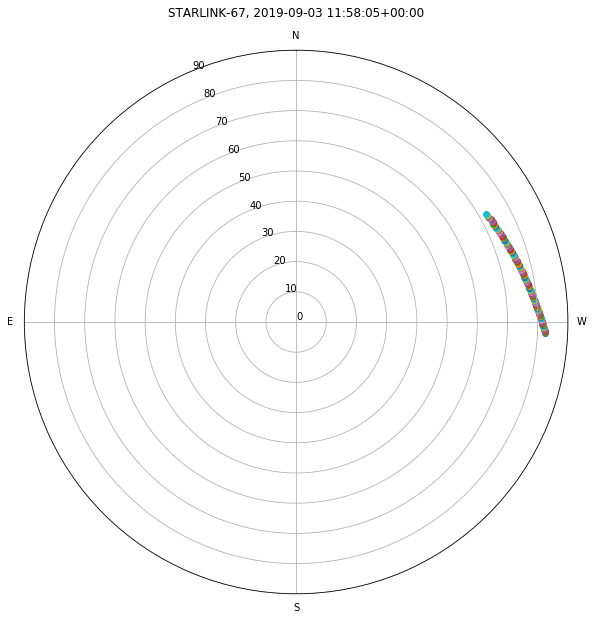

In [35]:
alt, az, ra, dec = starlink_visible(KPNO, t3, 110, 'STARLINK-67')
print(alt)

In [ ]:
def get_visible(where, tbegin, exptime, ra0, dec0, fov, satellites, groups=None, nsteps=10, oversampling=5, location = None):
	"""
	"""
	if groups is not None:
		satellitess={}
		for name in groups:
			satellitess.update(get_satellites(satellites, name))
		satellites=satellitess
	cos_dec0 = np.cos(np.deg2rad(dec0))
	# Calculate the end time of this exposure.
	tend = ts.utc(tbegin.utc_datetime() + datetime.timedelta(seconds=exptime))
	# Calculate the exposure midpoint.
	tmid = ts.tai_jd(0.5 * (tbegin.tai + tend.tai))
	# Calculate equal coarse time steps covering [tbegin, tend].
	tcoarse = np.linspace(tbegin.tai, tend.tai, nsteps)
	rcoarse = np.empty((3, nsteps))
	tsteps = ts.tai_jd(tcoarse)
	# Build a fine grid of time steps during the exposure for interpolation.
	tfine = np.linspace(tbegin.tai, tend.tai, oversampling * nsteps)
	# Loop over satellites.
	names, ravec, decvec = [], [], []
	plt.figure(figsize=(10,10))
	for i, satellite in enumerate(satellites.values()):
		# Calculate satellite position relative to the observer at each time step.
		topocentric = (satellite - where).at(tsteps)
		# Calculate the corresponding astrometric (ra, dec)
		ra, dec, _ = topocentric.radec()
		# Check for propagation errors.
		if np.any(np.isnan(ra.radians) | np.isnan(dec.radians)):
			#print(f'Unable to propagate {satellite.name}')
			continue
		# Tabulate the satellite position on the finer grid using cubic interpolation.
		rcoarse[0] = np.sin(dec.radians)
		rcoarse[1] = np.cos(ra.radians)
		rcoarse[2] = np.sin(ra.radians)
			#'''Why is cos(dec) not used?'''
		interpolator = scipy.interpolate.interp1d(
			tcoarse, rcoarse, axis=1, kind='cubic', copy=False,
			bounds_error=False, assume_sorted=True)
		sin_dec, cos_ra, sin_ra = interpolator(tfine)
		dec_deg = np.rad2deg(np.arcsin(sin_dec))
		ra_deg = np.fmod(360 + np.rad2deg(np.arctan2(sin_ra, cos_ra)), 360)
		# Does this satellite ever enter the fov?
		#sep = separation_matrix([ra0], [dec0], ra_deg, dec_deg, max_separation=0.6 * fov).reshape(-1)
		sep = separation_matrix([ra0], [dec0], ra_deg, dec_deg).reshape(-1)
		if sep.min() < 2 * fov:
			plt.plot(ra_deg, dec_deg, '.-', label=satellite.name)
			#names.append(satellite.name)
			ravec.append(ra_deg)
			decvec.append(dec_deg)
# 			plt.annotate(satellite.name, (ra_deg, dec_deg))
		if groups is not None:
			names.append(satellite.name)
# 	plt.xlim(ra0 - 2 * fov / cos_dec0, ra0 + 2 * fov / cos_dec0)
# 	plt.ylim(dec0 - 2 * fov, dec0 + 2 * fov)
	plt.xlim(ra0 - fov/2, ra0 + fov/2)
	plt.ylim(dec0 - fov/2, dec0 + fov/2)
	plt.xlabel('RA [deg]')
	plt.ylabel('DEC [deg]')
# 	plt.title(title)
	ax = plt.gca()
	ax.invert_xaxis()
	ax.set_aspect(1 / cos_dec0)
	#plt.xlim(ra0+15, ra0-15, nsteps)
	#plt.ylim(dec0-15, dec0+15, nsteps)
	# Draw circle showing fov.
	theta = np.linspace(0, 2 * np.pi, 50)
	x = ra0 + 0.5 * fov * np.cos(theta) / cos_dec0
	y = dec0 + 0.5 * fov * np.sin(theta)
	ax.plot(x, y, ls=':', c='gray', label='FOV')
	if location is not None:
		plt.legend(loc=location)
	else:
		plt.legend(loc='best')
	plt.grid()
# 	plt.savefig(title)
	return names, ravec, decvec

In [ ]:
names, ravec, decvec = get_visible(KPNO, t3, 110, 49.949648929729136, 31.89378374468902, 180, satellites_starlink)